<h1><center>Sepsis Prediction</h1>
<h4>TCSS 555<br>
Spring 2018<br>
Thuan Lam, Tood Robbins, Inno Irving Estrera</h4></center>


<h2>Libraries</h2>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from dateutil.parser import parse
from datetime import datetime

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Data

In [2]:
import os 
cwd = os.getcwd()
print('Current folder is {}'.format(cwd))

if os.name == "posix":
    unreadable = set([       
        "NEW_CHARTEVENTS.csv",
        "ADMISSIONS.csv",
        "NEW_ICUSTAYS.csv",
        "DRGCODES.csv"
    ])
    USER_DIR = '/Users/innoestrera/Desktop/mimic3/';
else:
    USER_DIR = 'C:\mimic3\\';
print(USER_DIR)

Current folder is C:\Users\toddr\Project-3-Sepsis
C:\mimic3\


In [3]:
# Load datasets
admissions = pd.read_csv("{}ADMISSIONS.csv".format(USER_DIR))[['HADM_ID','SUBJECT_ID','DIAGNOSIS']]
# convert Diagnosis to binary: 1 means sepsis
admissions['DIAGNOSIS'] = admissions['DIAGNOSIS'].apply(lambda x : 0 if str(x).find('SEPSIS') == -1 else 1)
# print(admissions.head(2))
# adminssions = shuffle(stays)

drugs = pd.read_csv("{}DRGCODES.csv".format(USER_DIR))[['HADM_ID','SUBJECT_ID','DRG_CODE','DESCRIPTION']]

stays = pd.read_csv("{}NEW_ICUSTAYS.csv".format(USER_DIR))[['HADM_ID','ICUSTAY_ID','LOS']]
# print(stays.head(1))

chart = pd.read_csv("{}NEW_CHARTEVENTS.csv".format(USER_DIR))
# print(chart.head(2))

## Create the Y Set

In [4]:
#get a copy with 2 columns only
find_sepsis = drugs[['HADM_ID', 'DRG_CODE']].copy()

#change drug code 870, 871, 872 to 1; Otherwise, 0
#https://www.icd10monitor.com/understanding-sepsis-an-example-of-the-convergence-of-clinical-quality-coding-reimbursement-and-audit
find_sepsis['DRG_CODE'] = find_sepsis['DRG_CODE'].apply(lambda x: 1 if (x >= 870 and x <= 872) or (x >= 867 and x <= 869) or x == 776 or (x >= 974 and x <= 976) else 0)

#sum all drugcodes grouup by HADM_ID. If the sum > 0 means HADM_ID has/had sepsis
find_sepsis = find_sepsis.groupby(['HADM_ID']).sum().reset_index() # .sort_values(by=['DRG_CODE'], ascending=False)

#convert DRG_CODE to binary: 1 means sepsis, 0 means NO
find_sepsis['DRG_CODE'] = find_sepsis['DRG_CODE'].apply(lambda x: 1 if x > 0 else 0)

#change DRG_CODR to SEPSIS, it would be easier 
find_sepsis.rename(columns={'DRG_CODE': 'SEPSIS'}, inplace=True)

# print('find_sepsis: ')
# print(find_sepsis.head(2))
# print('admission1: ')
# print(admissions.head(2))

#merge tables to create the Y set
admissions = pd.merge(admissions, find_sepsis, on='HADM_ID', how='left') #.drop(['SUBJECT_ID'], axis=1)
admissions = admissions.fillna(0)
# print('admission2: ')
# print(admissions.head(2))

# admissions.loc[admissions['SEPSIS'] > 0]

## Data Distribution of treated sepsis

HADM_ID       1763
SUBJECT_ID    1763
DIAGNOSIS     1763
SEPSIS        1763
dtype: int64


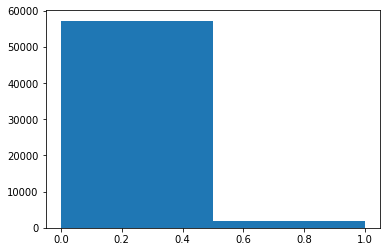

In [5]:
plt.hist(admissions.SEPSIS, bins=2)
print(admissions[admissions['SEPSIS']==1].count())

HADM_ID       1783
SUBJECT_ID    1783
DIAGNOSIS     1783
SEPSIS        1783
dtype: int64


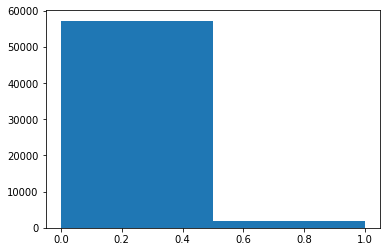

In [6]:
plt.hist(admissions.DIAGNOSIS, bins=2)
print(admissions[admissions['DIAGNOSIS']==1].count())

## Create the X Set

* <h3>Master

In [7]:
master = pd.merge(admissions, stays, on='HADM_ID', how='inner') #.drop(['SUBJECT_ID'], axis=1)
# print(master.head(3))

* <h3>Get ItemIDs from ChartEvents then Add into Master

In [8]:
# get itemsIds from ChartEvent
for x in chart.ITEMID.unique():
    master[x] = 0

# set index
master = master.set_index('ICUSTAY_ID')
# print(master.head(2))

* <h3>Put Item's Values into Master

In [9]:
for index, row in chart.iterrows():    
    master.loc[row['ICUSTAY_ID'], row['ITEMID']] = row['VALUE']
# print(master.head(2))

In [10]:
# move the SEPSIS column to the last 
cols = master.columns.tolist()
cols.insert(len(master.columns) - 1, cols.pop(cols.index('SEPSIS')))

master = master.reindex(columns= cols).reset_index()

In [11]:
# remove unnecessary columns
master.drop(['ICUSTAY_ID','HADM_ID','SUBJECT_ID', ], axis=1, inplace=True)
# print(master.head(2))
print('Master built. Shape: {}'.format(master.shape))
print(master.columns.values)

Master built. Shape: (51696, 13)
['DIAGNOSIS' 220615 225690 198 828 1525 490 226755 438 2981 227010 227023
 'SEPSIS']


In [12]:
master.fillna(0)
master = shuffle(master)
# master = master[:30000]

# ol_mask=master.isnull().any(axis=0) 
# ol_mask

## Model

In [13]:
# Split-out validation dataset
col = len(master.columns) - 1
array = master.values   #numpy array
X = array[:,0:col]# first N columns
Y = array[:,col]  # SEPSIS column

In [14]:
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)
# print('{}'.format(X_train, Y_train))

In [15]:
# Test options and evaluation metric
seed = 7
scoring = 'accuracy'

# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.964842 (0.003367)
KNN: 0.963802 (0.002896)
CART: 0.953380 (0.003025)
NB: 0.154342 (0.150835)
RF: 0.961118 (0.003634)


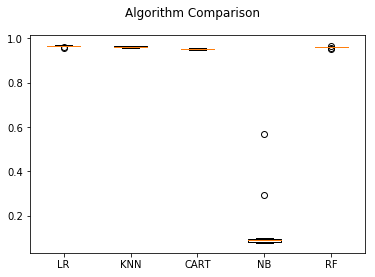

In [16]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [17]:
# Make predictions on validation dataset

messages = []
matrices = []
for name, model in models:
    model.fit(X_train, Y_train)
    prediction = model.predict(X_validation)
    
    accuracyScore = accuracy_score(Y_validation, prediction)
    confusionMatrix = confusion_matrix(Y_validation, prediction)
    classificationReport = classification_report(Y_validation, prediction)
    #precision, recall, thresholds = precision_recall_curve(Y_validation, prediction)
    sensitivity = confusionMatrix[0, 0]/(confusionMatrix[0, 0]+confusionMatrix[0, 1])
    specificity = confusionMatrix[1, 1]/(confusionMatrix[1, 0]+confusionMatrix[1, 1])
    
    print("accuracy", accuracyScore)
    print("confusion Matrix", confusionMatrix)
    print(classificationReport)
    print("sensitivity", sensitivity)
    print("specificity", specificity)
    #matrices.append(confusionMatrix)
    
#print(confusionMatrix)
#print(messages)

accuracy 0.9633462282398453
confusion Matrix [[9949   24]
 [ 355   12]]
             precision    recall  f1-score   support

        0.0       0.97      1.00      0.98      9973
        1.0       0.33      0.03      0.06       367

avg / total       0.94      0.96      0.95     10340

sensitivity 0.9975935024566329
specificity 0.0326975476839237
accuracy 0.9638297872340426
confusion Matrix [[9918   55]
 [ 319   48]]
             precision    recall  f1-score   support

        0.0       0.97      0.99      0.98      9973
        1.0       0.47      0.13      0.20       367

avg / total       0.95      0.96      0.95     10340

sensitivity 0.9944851097964504
specificity 0.1307901907356948
accuracy 0.9522243713733075
confusion Matrix [[9782  191]
 [ 303   64]]
             precision    recall  f1-score   support

        0.0       0.97      0.98      0.98      9973
        1.0       0.25      0.17      0.21       367

avg / total       0.94      0.95      0.95     10340

sensitivity 0.9

## Conclusion

<h4> Linear Regression and random forest are the best classifiers <h4>